In [1]:
import pandas as pd
import matplotlib.pyplot as mltp
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
import sklearn as sk
import seaborn as sea
import re 
from tqdm import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Laden der Inhalte aus den vorbereiteten Daten rein, welche basierend auf de Wortanzahl aber auch Sätzen selektiert wurden

In [2]:
def stripping(liste):
    return [i.strip() for i in liste]

In [3]:
df=pd.read_csv('data/train_500.csv',converters={'sent_tokenize': lambda x: x[1:-1].strip('][').replace("'","").strip().split(','),
'word_tokenize': lambda x: x[1:-1].strip('][').replace("'","").strip().split(','),
'word_tokenize_without_stopwords': lambda x: x[1:-1].strip('][').replace("'","").strip().split(',')
,'word_tokenize_without_stopwords_port': lambda x: x[1:-1].strip('][').replace("'","").strip().split(',')
,'msg_lemmatized': lambda x: x[1:-1].strip('][').replace("'","").strip().split(',')
})

df['word_tokenize']=df['word_tokenize'].progress_apply(stripping)
df['sent_tokenize']=df['sent_tokenize'].progress_apply(stripping)
df['word_tokenize_without_stopwords']=df['word_tokenize_without_stopwords'].progress_apply(stripping)
df['word_tokenize_without_stopwords_port']=df['word_tokenize_without_stopwords_port'].progress_apply(stripping)
df['word_tokenize_without_stopwords_port']=df['word_tokenize_without_stopwords_port'].progress_apply(stripping)

  0%|          | 0/19500 [00:00<?, ?it/s]

  0%|          | 0/19500 [00:00<?, ?it/s]

  0%|          | 0/19500 [00:00<?, ?it/s]

  0%|          | 0/19500 [00:00<?, ?it/s]

  0%|          | 0/19500 [00:00<?, ?it/s]

In [4]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df=df.reset_index(drop=True)

In [5]:
print(f'Rows in the df: {len(df.index)}')

Rows in the df: 19500


In [6]:
import random
import string
import nltk
from nltk import ngrams as get_ngrams


start_of_seq_token = "<START>"


class NgramModel(object):
    def __init__(self, n):
        self.n = n

        # dictionary that keeps list of candidate words given context
        self.context = {}
        self.ngram_counter_without_pre = {}

        # keeps track of how many times ngram has appeared in the text before
        self.ngram_counter = {}
        self.unique_count={}
        self.listen_append=[]


    def update(self, sentence: str,liste:list):
        """
        Updates the language model with an additional sentence (string)
        :param sentence: input text
        """
        liste=liste
        n = self.n
        sentence = (n-1) * [start_of_seq_token] + [w for w in nltk.word_tokenize(sentence) if w not in string.punctuation]
        ngrams = get_ngrams(sentence, n)
        for ngram in ngrams:
            #print(ngram)
            prev_words, target_word = ngram[:-1], ngram[-1]
            if (prev_words, target_word) in self.ngram_counter:
                self.ngram_counter[(prev_words, target_word)] += 1.0
            else:
                self.ngram_counter[(prev_words, target_word)] = 1.0


            if target_word in self.unique_count and target_word not in liste:
                liste.append(target_word)
                self.unique_count[target_word] += 1.0
                #print(1)

            elif target_word in self.unique_count and target_word  in liste:
                #print(2)
                pass
                
            else:
                #print(3)
                self.unique_count[target_word] = 1.0

            if target_word in self.ngram_counter_without_pre:
                
                self.ngram_counter_without_pre[target_word] += 1.0
            else:
                self.ngram_counter_without_pre[target_word] = 1.0

            if prev_words in self.context:
                if target_word not in self.context[prev_words]:
                    self.context[prev_words].append(target_word)
                else:
                    pass
            else:
                self.context[prev_words] = [target_word]
        return liste

    
    def prob(self, context, token):
        """
        Calculates probability of a candidate token to be generated given a context
        :return: conditional probability
        """
        try:
            count_of_token = self.ngram_counter[(context, token)]
            count_of_context = float(len(self.context[context]))
            result = count_of_token / count_of_context

        except KeyError:
            result = 0.0
            
        return result
    
    def random_token(self, context):
        """
        Given a context, selects the next word to append in a sequence
        :param context:
        :return:
        """
        r = random.random() / 50
        map_to_probs = {}
        token_of_interest = self.context[context]
        for token in token_of_interest:
            map_to_probs[token] = self.prob(context, token)

        summ = 0
        for token in sorted(map_to_probs):
            summ += map_to_probs[token]
            if summ > r:
                return token
        
        return next(sorted(map_to_probs))

    def generate_text(self, token_count: int):
        """
        :param token_count: number of words to be produced
        :return: generated text
        """
        n = self.n
        context_queue = (n - 1) * [start_of_seq_token]
        result = []
        for _ in range(token_count):
            obj = self.random_token(tuple(context_queue))
            result.append(obj)
            if n > 1:
                context_queue.pop(0)
                if obj == '.':
                    context_queue = (n - 1) * [start_of_seq_token]
                else:
                    context_queue.append(obj)
        return ' '.join(result)

In [8]:
model = NgramModel(n=2)
for x in tqdm(range(len(df.index))):
#for x in tqdm(range(3)):  
    sentences = [sent for sent in nltk.sent_tokenize(df['text'][x]) if sent]
    
    liste=[]
    for sent in sentences:
        #num=1
        #print(sent)
        liste=model.update(sent,liste)
        #liste=model.clac(sent,liste)
    #print(liste)

    
print(len(model.unique_count))

  0%|          | 0/19500 [00:00<?, ?it/s]

121338


Die Texte werden basierend auf ihren Inhalten analysiert, wobei die Wortanazahl gesamt, sowie des Auftretens der unterschiedlichen Texte Analysiert wird.

In [9]:
words_in_texts=pd.DataFrame(model.ngram_counter_without_pre,index=[0]).transpose().reset_index().rename(columns={'index':'word',0:'num'})
words_in_texts.head()

,word,num
0,This,3141.0
1,blog,2000.0
2,is,33051.0
3,being,2866.0
4,posted,339.0


In [10]:
words_in_texts=words_in_texts.loc[:, ~words_in_texts.columns.str.contains('^Unnamed')]
words_in_texts.sort_values(by= 'num',ascending=False).head()

,word,num
7,the,108773.0
41,I,100310.0
6,to,88167.0
51,and,72508.0
29,a,63895.0


In [11]:
count_overview=pd.DataFrame(model.unique_count,index=[0]).transpose().reset_index().rename(columns={'index':'word',0:'num'})
count_overview.to_csv('data/count_overview.csv')

In [12]:
count_overview=pd.read_csv('data/count_overview.csv')
count_overview=count_overview.loc[:, ~count_overview.columns.str.contains('^Unnamed')]
count_overview.sort_values(by= 'num',ascending=False).head()

,word,num
7,the,15931.0
6,to,15476.0
29,a,14476.0
51,and,14383.0
18,of,13460.0


In [13]:
count_overview.sort_values(by= 'num',ascending=False).head(20)

,word,num
7,the,15931.0
6,to,15476.0
29,a,14476.0
51,and,14383.0
18,of,13460.0
41,I,13141.0
79,in,12230.0
146,it,11858.0
2,is,11817.0
9,that,11724.0


In [14]:
count_ordnung=count_overview.sort_values(by= 'num',ascending=False)

In [15]:
words_that_are_often=count_ordnung[count_ordnung['num']>6000]
words_that_are_often

,word,num
7,the,15931.0
6,to,15476.0
29,a,14476.0
51,and,14383.0
18,of,13460.0
41,I,13141.0
79,in,12230.0
146,it,11858.0
2,is,11817.0
9,that,11724.0


In [16]:
words_in_texts=words_in_texts.sort_values(by= 'num',ascending=False)
words_in_texts.head()

,word,num
7,the,108773.0
41,I,100310.0
6,to,88167.0
51,and,72508.0
29,a,63895.0


In [17]:
words_in_texts[words_in_texts['num']>7000]

,word,num
7,the,108773.0
41,I,100310.0
6,to,88167.0
51,and,72508.0
29,a,63895.0
...,...,...
72,know,7559.0
43,if,7316.0
181,by,7199.0
327,would,7052.0


In [20]:
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 14.1 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [21]:
import spacy

nlp = spacy.load("en_core_web_md")
text_list=[]
lemma_list=[]
pos_list=[]
tag_list=[]
dep_list=[]
shape_list=[]
alpha_list=[]
stop_list=[]

for text in tqdm(df.text.tolist()):
    doc = nlp(text)
    text_list_word=[]
    lemma_list_word=[]
    pos_list_word=[]
    tag_list_word=[]
    dep_list_word=[]
    shape_list_word=[]
    alpha_list_word=[]
    stop_list_word=[]
    for token in doc:
        text_list_word.append(token.text)
        lemma_list_word.append(token.lemma_)
        pos_list_word.append(token.pos_)
        tag_list_word.append(token.tag_)
        dep_list_word.append(token.dep_)
        shape_list_word.append(token.shape_)
        alpha_list_word.append(token.is_alpha)
        stop_list_word.append(token.is_stop)
    text_list.append(text_list_word)
    lemma_list.append(lemma_list_word)
    pos_list.append(pos_list_word)
    tag_list.append(tag_list_word)
    dep_list.append(dep_list_word)
    shape_list.append(shape_list_word)
    alpha_list.append(alpha_list_word)
    stop_list.append(stop_list_word)
    #print(text_list)
d = {'text':df.text.tolist(),'text_list': text_list, 'lemma_list': lemma_list,'pos_list': pos_list, 'tag_list': tag_list,'dep_list': dep_list, 'shape_list': shape_list,'alpha_list': alpha_list, 'stop_list': stop_list,'gender':df.gender.tolist(),'sign':df.sign.tolist(),'topic':df.topic.tolist()}
df_text_spacy=pd.DataFrame(data=d)
    


  0%|          | 0/19500 [00:00<?, ?it/s]

In [22]:
df_text_spacy.head()

,text,text_list,lemma_list,pos_list,tag_list,dep_list,shape_list,alpha_list,stop_list,gender,sign,topic
0,This blog is being posted due to the fact that...,"[This, blog, is, being, posted, due, to, the, ...","[this, blog, be, be, post, due, to, the, fact,...","[DET, NOUN, AUX, AUX, VERB, ADP, ADP, DET, NOU...","[DT, NN, VBZ, VBG, VBN, IN, IN, DT, NN, IN, JJ...","[det, nsubjpass, aux, auxpass, ROOT, prep, pco...","[Xxxx, xxxx, xx, xxxx, xxxx, xxx, xx, xxx, xxx...","[True, True, True, True, True, True, True, Tru...","[True, False, True, True, False, True, True, T...",male,Sagittarius,Student
1,So I have a big fucking interview tomorrow for...,"[So, I, have, a, big, fucking, interview, tomo...","[so, I, have, a, big, fucking, interview, tomo...","[ADV, PRON, VERB, DET, ADJ, ADJ, NOUN, NOUN, A...","[RB, PRP, VBP, DT, JJ, JJ, NN, NN, IN, PRP$, J...","[advmod, nsubj, ROOT, det, amod, amod, dobj, n...","[Xx, X, xxxx, x, xxx, xxxx, xxxx, xxxx, xxx, x...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, False, False, False, ...",male,Pisces,Student
2,I was reminded just now of the time Ashley and...,"[I, was, reminded, just, now, of, the, time, A...","[I, be, remind, just, now, of, the, time, Ashl...","[PRON, AUX, VERB, ADV, ADV, ADP, DET, NOUN, PR...","[PRP, VBD, VBN, RB, RB, IN, DT, NN, NNP, CC, P...","[nsubjpass, auxpass, ROOT, advmod, advmod, pre...","[X, xxx, xxxx, xxxx, xxx, xx, xxx, xxxx, Xxxxx...","[True, True, True, True, True, True, True, Tru...","[True, True, False, True, True, True, True, Fa...",female,Gemini,Student
3,I was checking up on my cousin Dylan and Fanni...,"[I, was, checking, up, on, my, cousin, Dylan, ...","[I, be, check, up, on, my, cousin, Dylan, and,...","[PRON, AUX, VERB, ADP, ADP, PRON, NOUN, PROPN,...","[PRP, VBD, VBG, RP, IN, PRP$, NN, NNP, CC, NNP...","[nsubj, aux, ROOT, prt, prep, poss, pobj, poss...","[X, xxx, xxxx, xx, xx, xx, xxxx, Xxxxx, xxx, X...","[True, True, True, True, True, True, True, Tru...","[True, True, False, True, True, True, False, F...",female,Taurus,Student
4,for the NME interview click urlLink part 1 and...,"[for, the, NME, interview, click, urlLink, par...","[for, the, NME, interview, click, urllink, par...","[SCONJ, DET, PROPN, NOUN, VERB, NOUN, NOUN, NU...","[IN, DT, NNP, NN, VB, NN, NN, CD, CC, VB, NN, CD]","[mark, det, compound, nsubj, ROOT, dobj, dobj,...","[xxx, xxx, XXX, xxxx, xxxx, xxxXxxx, xxxx, d, ...","[True, True, True, True, True, True, True, Fal...","[True, True, False, False, False, False, True,...",female,Aquarius,Student


In [23]:
from nltk.corpus import stopwords
def stopwords_count_and_removal(data, col, language="english"):

    stoplist = stopwords.words(language)

    number_of_stopwords = []
    text_without_stopwords = []

    col_name_number_of_stopwords = col + "_num_of_stopwords"
    col_name_without_stopwords = col + "_without_stopwords"

    for i in tqdm(range(len(data))):
        no_of_words = 0
        without_stopwords = []
        for word in data[col][i]:
            if word in stoplist:
                no_of_words += 1
            else:
                without_stopwords.append(word)
        
        text_without_stopwords.append(without_stopwords)
        number_of_stopwords.append(no_of_words)

    data[col_name_number_of_stopwords] = number_of_stopwords
    data[col_name_without_stopwords] = text_without_stopwords


    return data

In [24]:
df_text_spacy=stopwords_count_and_removal(df_text_spacy,'lemma_list')

  0%|          | 0/19500 [00:00<?, ?it/s]

# LDA

In [83]:
import numpy as np
import json
import glob

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from nltk.corpus import stopwords

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import pickle 

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

Stoppwörter sind häufig vorkommende Wörter in einer Sprache, die für sich genommen nicht viel Bedeutung haben und bei der Verarbeitung natürlicher Sprache (NLP) häufig entfernt werden. Zu diesen Wörtern gehören u. a. Artikel, Konjunktionen und Präpositionen.

Es gibt mehrere Gründe, warum Stoppwörter im NLP häufig entfernt werden. Ein Grund ist, dass Stoppwörter keinen großen Informationsgehalt haben und nicht wesentlich zur Bedeutung eines Satzes beitragen. Daher kann das Entfernen von Stoppwörtern den Umfang des Wortschatzes verringern und die Verarbeitung des Textes erleichtern.

Ein weiterer Grund für die Entfernung von Stoppwörtern ist, dass sie bei bestimmten NLP-Aufgaben stören können. Bei Aufgaben der Informationsbeschaffung, wie z. B. Suchmaschinen, können Stoppwörter besonders problematisch sein, da sie so häufig vorkommen und kaum nützliche Informationen für die Einstufung von Suchergebnissen liefern. In solchen Fällen kann das Entfernen von Stoppwörtern die Leistung des Systems verbessern.

Zusammenfassend lässt sich sagen, dass Stoppwörter bei NLP-Aufgaben oft entfernt werden, welches in diesem Fall getan wird, weil sie kaum Informationen enthalten, bestimmte Aufgaben behindern und die Verarbeitung des Textes erleichtern können. Es gibt zwar Situationen, in denen Stoppwörter nützlich sein können, aber im Allgemeinen werden sie nicht als so wichtig angesehen wie andere Wörter in einem Satz und werden oft als Vorverarbeitungsschritt entfernt.


In [84]:
stopwords = stopwords.words('english')

In [85]:
text_liste=df_text_spacy.text.tolist()
text_liste[0][0:90]

'This blog is being posted due to the fact that little development has happened recently re'

SpaCy ist eine beliebte Open-Source-Bibliothek für die Verarbeitung natürlicher Sprache (NLP) in Python. Sie enthält unter anderem Werkzeuge für Tokenisierung, Part-of-Speech-Tagging, Dependency Parsing und Named Entity Recognition. Diese Werkzeuge sind in einer Pipeline organisiert, die den Eingabetext verarbeitet und eine Vielzahl von linguistischen Merkmalen extrahiert, die für eine Vielzahl von NLP-Aufgaben verwendet werden können.

Der erste Schritt in der SpaCy-Pipeline ist die Tokenisierung, d. h. die Zerlegung des Eingabetextes in einzelne Wörter (Token). Dies geschieht anhand einer Reihe von Regeln, die Interpunktion, Kontraktionen und andere Sonderfälle berücksichtigen. Die so entstandenen Token werden dann mit verschiedenen linguistischen Merkmalen versehen, z. B. mit ihrem Part-of-Speech-Tag und ihrem Lemma (Grundform).

Der nächste Schritt in der Pipeline ist das Part-of-Speech-Tagging, bei dem jedes Token mit seinem Part of Speech (z. B. Substantiv, Verb oder Adjektiv) gekennzeichnet wird. Dies geschieht in der Regel mithilfe eines maschinellen Lernmodells, das auf einem großen annotierten Textkorpus trainiert wurde. Das Part-of-Speech-Tagging ist ein wichtiger Schritt, da es dem Modell ermöglicht, die grammatikalische Rolle jedes Wortes im Satz zu identifizieren, was für Aufgaben wie Dependency Parsing und Named Entity Recognition nützlich sein kann.

Beim Dependency Parsing werden die Beziehungen zwischen Wörtern in einem Satz identifiziert, z. B. Subjekt-Verben-Beziehungen und Modifikator-Kopf-Beziehungen. Dies geschieht in der Regel mithilfe eines maschinellen Lernmodells, das auf einem großen annotierten Textkorpus trainiert wurde. Das Parsen von Abhängigkeiten ist ein wichtiger Schritt, da es dem Modell ermöglicht, die Struktur des Satzes und die Beziehungen zwischen den Wörtern zu verstehen, was für Aufgaben wie die Informationsextraktion und die maschinelle Übersetzung nützlich sein kann. Jedoch wird dies Aufgrund der Anwendung ncith verwendet, da dies meist mit den höchsten Aufwand erzeugt

Bei der Erkennung benannter Entitäten handelt es sich um den Prozess der Identifizierung und Klassifizierung benannter Entitäten in Texten, z. B. Personen, Organisationen und Orte. Dies geschieht in der Regel mithilfe eines maschinellen Lernmodells, das auf einem großen kommentierten Textkorpus trainiert wurde. Die Erkennung von benannten Entitäten ist ein wichtiger Schritt, da sie es dem Modell ermöglicht, strukturierte Informationen aus unstrukturiertem Text zu extrahieren, was für Aufgaben wie die Informationsextraktion und die Textklassifizierung nützlich sein kann.

Insgesamt ist die SpaCy-Pipeline ein leistungsfähiges Werkzeug zur Extraktion einer Vielzahl von linguistischen Merkmalen aus Text, die für eine Vielzahl von NLP-Aufgaben verwendet werden können. Durch die Kombination dieser Merkmale mit Modellen des maschinellen Lernens ist es möglich, anspruchsvolle NLP-Anwendungen zu erstellen, die natürlichsprachliche Texte analysieren und verstehen können.


In [86]:
def lemmatization_test(texts,  allowed_posttags=['NOUN','ADJ','VERB','ADV']):
    nlp=spacy.load('en_core_web_md',disable=['parser','ner'])
    texts_out=[]
    for text in tqdm(texts):
        doc= nlp(text)
        new_text=[]
        for token in doc:
            if token.pos_ in allowed_posttags:
                new_text.append(token.lemma_)
        final=' '.join(new_text)
        texts_out.append(final)
    return texts_out

In [87]:
lemma_text=lemmatization_test(text_liste)

  0%|          | 0/19500 [00:00<?, ?it/s]

In [88]:
print(lemma_text[0][0:90])

blog post fact little development happen recently regard last day school uniform swap plan


In [89]:
def gen_words(texts):
    final=[]
    for text in tqdm(texts):
        new= gensim.utils.simple_preprocess(text,deacc=True)
        final.append(new)
    return final

In [90]:
data_words=gen_words(lemma_text)

  0%|          | 0/19500 [00:00<?, ?it/s]

In [91]:
print(data_words[0][0:90])

['blog', 'post', 'fact', 'little', 'development', 'happen', 'recently', 'regard', 'last', 'day', 'school', 'uniform', 'swap', 'plan', 'switch', 'uniform', 'certain', 'individual', 'somehow', 'organize', 'soon', 'also', 'consider', 'last', 'day', 'school', 'think', 'participate', 'success', 'plan', 'soon', 'pray', 'drop', 'dress', 'code', 'day', 'last', 'day', 'school']


### Bigrams and Trigrams

Ein n-Gramm ist eine zusammenhängende Sequenz von n Elementen aus einer bestimmten Text- oder Sprachprobe. N-Gramme sind in der natürlichen Sprachverarbeitung und Computerlinguistik weit verbreitet. Sie können für eine Vielzahl von Aufgaben verwendet werden, z. B. für die Sprachmodellierung, die Informationsbeschaffung und die maschinelle Übersetzung.

Bigramme sind Zwei-Wort-Folgen von Wörtern, die nacheinander in einem Text vorkommen. In dem Satz "die Katze im Hut" wären die Bigramme zum Beispiel "die Katze", "Katze in" und "in der". Bigramme können für Aufgaben wie Rechtschreibkorrektur, Sprachmodellierung und Informationsabfrage nützlich sein.

Trigramme sind Drei-Wort-Folgen von Wörtern, die nacheinander in einem Text vorkommen. In dem Satz "die Katze im Hut" wären die Trigramme zum Beispiel "die Katze in", "die Katze im" und "im Hut". Trigramme können für Aufgaben wie Sprachmodellierung und Informationsabfrage nützlich sein.

N-Gramme werden häufig in der natürlichen Sprachverarbeitung verwendet, da sie den Kontext und die Bedeutung von Wörtern in einem Text erfassen können. Beispielsweise ist das Bigramm "New York" informativer als die einzelnen Wörter "New" und "York", da es darauf hindeutet, dass die beiden Wörter miteinander verwandt sind und sich wahrscheinlich auf die Stadt beziehen. In ähnlicher Weise ist das Trigramm "die Katze in" informativer als die Bigramme "die Katze" und "Katze in", da es darauf hindeutet, dass die Wörter Teil einer Sequenz sind und wahrscheinlich in irgendeiner Weise miteinander in Beziehung stehen.

Insgesamt können n-Gramme ein nützliches Werkzeug für das Verständnis und die Verarbeitung von Sprachdaten sein, und Bigramme und Trigramme werden häufig in einer Vielzahl von Aufgaben der natürlichen Sprachverarbeitung verwendet.


In [92]:
bigram_phrases=gensim.models.Phrases(data_words,min_count=3,threshold=100)
trigram_phases=gensim.models.Phrases(bigram_phrases[data_words],threshold=50)

bigram=gensim.models.phrases.Phraser(bigram_phrases)
trigram=gensim.models.phrases.Phraser(trigram_phases)

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trgram(texts):
    return [trigram[bigram[doc]] for doc in texts]

data_bigrams=make_bigrams(data_words)
data_bigrams_trigrams=make_trgram(data_bigrams)

In [93]:
from gensim.models import TfidfModel

id2word=corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus=[id2word.doc2bow(text) for text in texts]

print(corpus[0][0:90])

tfidf=TfidfModel(corpus,id2word=id2word)

low_value=0.03
words=[]
words_missing_in_tfdf=[]

for i in tqdm(range(0,len(corpus))):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops=low_value_words+words_missing_in_tfdf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  
    corpus[i]=new_bow


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 4), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 3), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2)]


  0%|          | 0/19500 [00:00<?, ?it/s]

Ein wichtiger aber auch schwieriger Aspekt des LDA prozesses ist die Bestimmung der ANzhal der Topics. Hierbei ist wie bei Maschine Learning eine autonmatische Verbesserung und Lernen nicht gegeben, weshlab durch erforschen und Analysen die Optimalen Parameter gefunden werden müssen. Dies ist besonders schweirig, da meist Klassen entstehen, welche eine hohe Anzahl an Elementen enthalten

In [275]:
num_topics=24

In [276]:
lda_model=gensim.models.ldamodel.LdaModel(
corpus=corpus,
id2word=id2word,
num_topics=num_topics,
random_state=100,
update_every=1,
chunksize=100,
passes=10,
alpha='auto'
)

In [277]:
dic={}
dic_sum={}
for idx, topic in lda_model.print_topics(num_topics,num_words=100):
    elements=[]
    percent=[]

    for e in topic.split('+'):
        elements.append(e.split('*')[1].replace('"','').strip())
        percent.append(float(e.split('*')[0].replace('"','').strip()))

    dic[str(idx)+'_word']=elements
    dic[str(idx)+'_per']=percent
    dic_sum[idx]=sum(percent)
print(dic_sum)

{0: 0.679, 1: 0.8040000000000003, 2: 0.8300000000000002, 3: 0.8330000000000002, 4: 0.9620000000000006, 5: 0.8430000000000003, 6: 0.8890000000000003, 7: 0.8810000000000003, 8: 0.9700000000000005, 9: 0.8280000000000003, 10: 0.673, 11: 0.9480000000000006, 12: 0.8350000000000003, 13: 0.8620000000000002, 14: 0.8540000000000003, 15: 0.8670000000000002, 16: 0.8850000000000003, 17: 0.9760000000000006, 18: 0.8010000000000002, 19: 0.7320000000000002, 20: 0.6740000000000002, 21: 0.8180000000000001, 22: 0.8680000000000001, 23: 0.9320000000000006}


Zur bestimmung der optimalen Anzahl von relevanten Wörtern wurden daher auf 100 gestzt, um nah an 100% zu sein. Da je nach Wort eine untershciedliche Wahrscheinlichkeit und Somit gewichtung für das eine oder andere Topic entsteht

Daher werden die Wörter im nahchinein genutzt, um eine zurodnung durch abgleich und multiplikation der Gewichtung zu erziehlen, um basierend davon jenes Topic zu deklarieren, welches am Wahrscheinlichsten ist. Aus diesem Grund dies aus dem Wert der Summe der auftretenden Werte verglichen mit der Summe der Unterschiedlichen Gewichte mäglicher alternastiven Topics
Dafür wird volgendes getan:
1. Identifizieren, welche Wörter eines Topics und wei oft in einem Text enthalten sind
2. Basierend auf diesen die Wahrscheinlihckeiten bestimmen
3. Diese Addieren und den höchsten Wert identifizieren, welche das Wahrschienlichste Topic entspricht


In [278]:
df_topic=pd.DataFrame(data=dic)
df_topic.head()

,0_word,0_per,1_word,1_per,2_word,2_per,3_word,3_per,4_word,4_per,...,19_word,19_per,20_word,20_per,21_word,21_per,22_word,22_per,23_word,23_per
0,rule,0.120,car,0.198,rain,0.063,song,0.164,look,0.075,...,parent,0.138,throw,0.159,nbsp,0.659,urllink,0.771,know,0.037
1,hair,0.109,food,0.124,return,0.054,fuck,0.077,like,0.050,...,mother,0.092,shoot,0.102,comment,0.099,ton,0.023,think,0.036
2,box,0.099,shit,0.112,son,0.053,rock,0.063,put,0.044,...,smile,0.074,season,0.093,it,0.031,traffic,0.019,make,0.030
3,lack,0.084,ride,0.082,bag,0.048,fire,0.050,show,0.041,...,energy,0.050,match,0.067,function,0.010,bird,0.014,say,0.030
4,detail,0.042,shoe,0.058,sun,0.047,burn,0.048,part,0.030,...,block,0.042,last,0.058,posting,0.010,quiz,0.012,people,0.029


In [279]:
%%time
topic_of_text=[]
for text in tqdm(data_words):
    liste_text_top=[]
    for t in range(num_topics):
        liste_top=[]
        for element in df_topic[f'{t}_word'].tolist():
            liste_top.append(len([i for i, e in enumerate(text) if e == element]))
   
        Result = []
        for i1, i2 in zip(liste_top, df_topic[f'{t}_per'].tolist()):
            Result.append(i1*i2)
        liste_text_top.append(sum(Result))    
    if sum(liste_text_top)!=0:
        topic_of_text.append([max(range(len(liste_text_top)), key=liste_text_top.__getitem__),max(liste_text_top)/sum(liste_text_top),liste_text_top])
    else:
        topic_of_text.append(['None','None',liste_text_top])

       


  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 1min 27s, sys: 614 ms, total: 1min 28s
Wall time: 1min 28s


In [280]:
df_übersicht=pd.DataFrame(data=topic_of_text,columns=['topic_num','percent','perc_list'])

In [281]:
df_übersicht.topic_num.value_counts().index.tolist()

[8, 22, 21, 17]

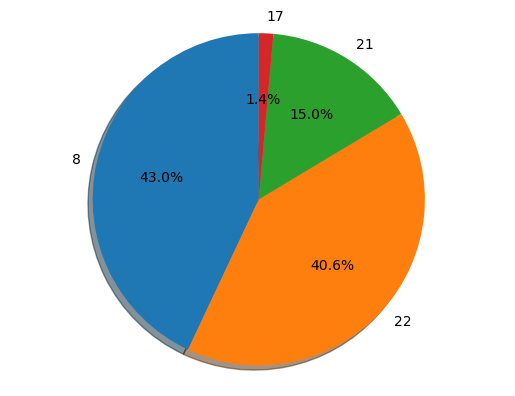

In [282]:
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(df_übersicht.topic_num.value_counts().tolist(),  labels=df_übersicht.topic_num.value_counts().index.tolist(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [283]:
overview=pd.merge(df[['text','topic']], df_übersicht, left_index=True, right_index=True)
overview.head()

,text,topic,topic_num,percent,perc_list
0,This blog is being posted due to the fact that...,Student,21,0.234972,"[0.9750000000000002, 1.071, 0.548, 0.911000000..."
1,So I have a big fucking interview tomorrow for...,Student,21,0.261081,"[0.127, 0.936, 0.533, 0.6670000000000001, 3.04..."
2,I was reminded just now of the time Ashley and...,Student,21,0.169171,"[0.8230000000000001, 1.889, 0.4690000000000000..."
3,I was checking up on my cousin Dylan and Fanni...,Student,8,0.200605,"[0.31400000000000006, 1.977, 0.551999999999999..."
4,for the NME interview click urlLink part 1 and...,Student,22,0.204323,"[0.43000000000000005, 0.7080000000000001, 0.40..."


In [284]:
overview[overview.topic=='Student'].topic_num.value_counts()

8     215
22    203
21     75
17      7
Name: topic_num, dtype: int64

In [285]:
tes=['a','b','c','d']
[i for i, e in enumerate([1, 2, 1]) if e == 0]

[]

In [286]:
len([i for i, e in enumerate([1, 2, 1]) if e == 0])

0

In [287]:
for idx, topic in lda_model.print_topics(num_topics,num_words=30):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.120*"rule" + 0.109*"hair" + 0.099*"box" + 0.084*"lack" + 0.042*"detail" + 0.041*"rant" + 0.029*"dunno" + 0.029*"yard" + 0.024*"skill" + 0.018*"midnight" + 0.017*"candidate" + 0.017*"vision" + 0.017*"wrong" + 0.016*"skip" + 0.011*"tone" + 0.004*"webpage" + 0.002*"what" + 0.000*"picture" + 0.000*"bowl" + 0.000*"kid" + 0.000*"area" + 0.000*"woman" + 0.000*"swear" + 0.000*"dream" + 0.000*"ant" + 0.000*"town" + 0.000*"attempt" + 0.000*"serve" + 0.000*"concept" + 0.000*"cheese"
Topic: 1 
Words: 0.198*"car" + 0.124*"food" + 0.112*"shit" + 0.082*"ride" + 0.058*"shoe" + 0.054*"cook" + 0.030*"chicken" + 0.028*"kiss" + 0.021*"playing" + 0.017*"pig" + 0.016*"vehicle" + 0.016*"monkey" + 0.015*"grill" + 0.014*"bullshit" + 0.007*"entertain" + 0.006*"drown" + 0.003*"on" + 0.003*"brownie" + 0.000*"cheese" + 0.000*"kid" + 0.000*"town" + 0.000*"sauce" + 0.000*"woman" + 0.000*"smoke" + 0.000*"wife" + 0.000*"serve" + 0.000*"pair" + 0.000*"pepper" + 0.000*"pair_shoe" + 0.000*"crust"
Topic

## Visualisation

In [288]:

import pyLDAvis.gensim_models as gensimvis
import pickle 
pyLDAvis.enable_notebook()
import os
LDAvis_data_filepath = os.path.join('pic/test_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word,mds='mmds',R=30)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'pic/test_'+ str(num_topics) +'.html')
LDAvis_prepared

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative use

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
23     0.333779  0.441274       1        1  35.114038
17    -0.386564  0.374009       2        1  18.655591
4      0.063221  0.507394       3        1   9.082211
8     -0.176217  0.465263       4        1   7.568181
11    -0.521201  0.012360       5        1   6.317133
6     -0.347431  0.156379       6        1   2.074696
7      0.455543  0.038767       7        1   1.942140
16    -0.208957 -0.420997       8        1   1.881553
15     0.202300  0.106881       9        1   1.625653
14     0.116589  0.279617      10        1   1.500037
13     0.355534  0.183519      11        1   1.465840
5     -0.366249 -0.151576      12        1   1.451750
22     0.299920 -0.351175      13        1   1.355175
9     -0.015863 -0.433110      14        1   1.302827
2     -0.290583 -0.277961      15        1   1.218482
12     0.388044 -0.195728      16        1   1.182018
3     -0.083900  0.231220      17        1   1.177908
18     0.141192 -0.371053      18        1   0.980978
1     -0.233287  0.017562      19        1   0.903002
21    -0.017036 -0.276301      20        1   0.842803
19     0.283888 -0.083072      21        1   0.736940
0     -0.013958  0.012468      22        1   0.583555
20     0.125465 -0.136256      23        1   0.536203
10    -0.104231 -0.129485      24        1   0.501285, topic_info=         Term          Freq         Total Category  logprob  loglift
26         go  21411.000000  21411.000000  Default   30.000  30.0000
146   urllink   9149.000000   9149.000000  Default   29.000  29.0000
77        get  19770.000000  19770.000000  Default   28.000  28.0000
1029     nbsp   4861.000000   4861.000000  Default   27.000  27.0000
3         day   8892.000000   8892.000000  Default   26.000  26.0000
...       ...           ...           ...      ...      ...      ...
1730    order      0.043759      1.308971  Topic24  -11.516   1.8975
2432    style      0.043759      1.308970  Topic24  -11.516   1.8975
1741  picture      0.043759      1.308975  Topic24  -11.516   1.8975
2054     sell      0.043759      1.308971  Topic24  -11.516   1.8975
1965    woman      0.043759      1.308975  Topic24  -11.516   1.8975

[867 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1543     16  0.981800     accent
1525      9  0.993802     access
637      12  0.995826    account
406       6  0.998179     action
1276     10  0.990094   activity
...     ...       ...        ...
261       1  0.999577      write
1624     22  0.981305      wrong
236      22  0.988293       yard
262       1  0.999787       year
1231      4  0.999428  yesterday

[644 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[24, 18, 5, 9, 12, 7, 8, 17, 16, 15, 14, 6, 23, 10, 3, 13, 4, 19, 2, 22, 20, 1, 21, 11])

In [289]:
pyLDAvis.enable_notebook()
vis=gensimvis.prepare(lda_model,corpus,id2word,mds='mmds',R=30)
vis

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/niclascrame

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
23     0.333779  0.441274       1        1  35.114034
17    -0.386564  0.374009       2        1  18.655592
4      0.063221  0.507394       3        1   9.082213
8     -0.176217  0.465263       4        1   7.568180
11    -0.521201  0.012360       5        1   6.317134
6     -0.347431  0.156379       6        1   2.074696
7      0.455543  0.038767       7        1   1.942140
16    -0.208957 -0.420997       8        1   1.881553
15     0.202300  0.106881       9        1   1.625653
14     0.116589  0.279617      10        1   1.500037
13     0.355534  0.183519      11        1   1.465840
5     -0.366249 -0.151576      12        1   1.451750
22     0.299920 -0.351175      13        1   1.355175
9     -0.015863 -0.433110      14        1   1.302827
2     -0.290583 -0.277961      15        1   1.218483
12     0.388044 -0.195728      16        1   1.182018
3     -0.083900  0.231220      17        1   1.177908
18     0.141192 -0.371053      18        1   0.980978
1     -0.233287  0.017562      19        1   0.903002
21    -0.017036 -0.276301      20        1   0.842803
19     0.283888 -0.083072      21        1   0.736940
0     -0.013958  0.012468      22        1   0.583555
20     0.125465 -0.136256      23        1   0.536203
10    -0.104231 -0.129485      24        1   0.501285, topic_info=         Term          Freq         Total Category  logprob  loglift
26         go  21411.000000  21411.000000  Default   30.000  30.0000
146   urllink   9149.000000   9149.000000  Default   29.000  29.0000
77        get  19770.000000  19770.000000  Default   28.000  28.0000
1029     nbsp   4861.000000   4861.000000  Default   27.000  27.0000
3         day   8892.000000   8892.000000  Default   26.000  26.0000
...       ...           ...           ...      ...      ...      ...
1730    order      0.043759      1.308971  Topic24  -11.516   1.8975
2432    style      0.043759      1.308970  Topic24  -11.516   1.8975
1741  picture      0.043759      1.308975  Topic24  -11.516   1.8975
2054     sell      0.043759      1.308971  Topic24  -11.516   1.8975
1965    woman      0.043759      1.308975  Topic24  -11.516   1.8975

[867 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1543     16  0.981800     accent
1525      9  0.993802     access
637      12  0.995826    account
406       6  0.998179     action
1276     10  0.990094   activity
...     ...       ...        ...
261       1  0.999577      write
1624     22  0.981305      wrong
236      22  0.988293       yard
262       1  0.999787       year
1231      4  0.999428  yesterday

[644 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[24, 18, 5, 9, 12, 7, 8, 17, 16, 15, 14, 6, 23, 10, 3, 13, 4, 19, 2, 22, 20, 1, 21, 11])

# Nur Nomen und Verben

In [290]:
lemma_text_NV=lemmatization_test(text_liste,['NOUN','VERB'])

  0%|          | 0/19500 [00:00<?, ?it/s]

In [291]:
data_words_NV=gen_words(lemma_text_NV)

  0%|          | 0/19500 [00:00<?, ?it/s]

In [292]:
bigram_phrases_NV=gensim.models.Phrases(data_words_NV,min_count=3,threshold=100)
trigram_phases_NV=gensim.models.Phrases(bigram_phrases_NV[data_words_NV],threshold=50)

bigram_NV=gensim.models.phrases.Phraser(bigram_phrases_NV)
trigram_NV=gensim.models.phrases.Phraser(trigram_phases_NV)

def make_bigrams(bigram,texts):
    return [bigram[doc] for doc in texts]

def make_trgram(trigram,bigram,texts):
    return [trigram[bigram[doc]] for doc in texts]

data_bigrams_NV=make_bigrams(bigram_NV,data_words_NV)
data_bigrams_trigrams_NV=make_trgram(trigram_NV,bigram_NV,data_bigrams_NV)

In [293]:
from gensim.models import TfidfModel

id2word=corpora.Dictionary(data_bigrams_trigrams_NV)

texts = data_bigrams_trigrams_NV

corpus=[id2word.doc2bow(text) for text in texts]

print(corpus[0][0:90])

tfidf=TfidfModel(corpus,id2word=id2word)

low_value=0.03
words=[]
words_missing_in_tfdf=[]

for i in tqdm(range(0,len(corpus))):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops=low_value_words+words_missing_in_tfdf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  
    corpus[i]=new_bow


[(0, 1), (1, 1), (2, 1), (3, 4), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 3), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2)]


  0%|          | 0/19500 [00:00<?, ?it/s]

In [294]:
lda_model=gensim.models.ldamodel.LdaModel(
corpus=corpus,
id2word=id2word,
num_topics=num_topics,
random_state=100,
update_every=1,
chunksize=100,
passes=10,
alpha='auto'
)

In [295]:
dic={}
dic_sum={}
for idx, topic in lda_model.print_topics(num_topics,num_words=100):
    elements=[]
    percent=[]

    for e in topic.split('+'):
        elements.append(e.split('*')[1].replace('"','').strip())
        percent.append(float(e.split('*')[0].replace('"','').strip()))

    dic[str(idx)+'_word']=elements
    dic[str(idx)+'_per']=percent
    dic_sum[idx]=sum(percent)
print(dic_sum)

{0: 0.679, 1: 0.8040000000000003, 2: 0.8300000000000002, 3: 0.8330000000000002, 4: 0.9620000000000006, 5: 0.8430000000000003, 6: 0.8890000000000003, 7: 0.8810000000000003, 8: 0.9700000000000005, 9: 0.8280000000000003, 10: 0.673, 11: 0.9480000000000006, 12: 0.8350000000000003, 13: 0.8620000000000002, 14: 0.8540000000000003, 15: 0.8670000000000002, 16: 0.8850000000000003, 17: 0.9760000000000006, 18: 0.8010000000000002, 19: 0.7320000000000002, 20: 0.6740000000000002, 21: 0.8180000000000001, 22: 0.8680000000000001, 23: 0.9320000000000006}


In [296]:
pd.DataFrame(data=dic)

,0_word,0_per,1_word,1_per,2_word,2_per,3_word,3_per,4_word,4_per,...,19_word,19_per,20_word,20_per,21_word,21_per,22_word,22_per,23_word,23_per
0,rule,0.120,car,0.198,rain,0.063,song,0.164,look,0.075,...,parent,0.138,throw,0.159,nbsp,0.659,urllink,0.771,know,0.037
1,hair,0.109,food,0.124,return,0.054,fuck,0.077,like,0.050,...,mother,0.092,shoot,0.102,comment,0.099,ton,0.023,think,0.036
2,box,0.099,shit,0.112,son,0.053,rock,0.063,put,0.044,...,smile,0.074,season,0.093,it,0.031,traffic,0.019,make,0.030
3,lack,0.084,ride,0.082,bag,0.048,fire,0.050,show,0.041,...,energy,0.050,match,0.067,function,0.010,bird,0.014,say,0.030
4,detail,0.042,shoe,0.058,sun,0.047,burn,0.048,part,0.030,...,block,0.042,last,0.058,posting,0.010,quiz,0.012,people,0.029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,bother,0.000,depend,0.000,writing,0.000,ju,0.000,profile,0.001,...,author,0.000,truck,0.000,journalism,0.000,drag,0.000,answer,0.002
96,depend,0.000,stir,0.000,toss,0.000,attempt,0.000,scratch,0.001,...,stir,0.000,retrieve,0.000,restore,0.000,table,0.000,bunch,0.002
97,wall,0.000,spread,0.000,require,0.000,cast,0.000,medicine,0.001,...,prefer,0.000,smell,0.000,lay,0.000,version,0.000,beer,0.002
98,package,0.000,garlic,0.000,search,0.000,process,0.000,cinema,0.001,...,attempt,0.000,bug,0.000,vu,0.000,bus,0.000,touch,0.002


In [297]:
pyLDAvis.enable_notebook()
vis=gensimvis.prepare(lda_model,corpus,id2word,mds='mmds',R=30)
vis

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/niclascrame

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
23     0.333779  0.441274       1        1  35.114038
17    -0.386564  0.374009       2        1  18.655591
4      0.063221  0.507394       3        1   9.082211
8     -0.176217  0.465263       4        1   7.568181
11    -0.521201  0.012360       5        1   6.317133
6     -0.347431  0.156379       6        1   2.074696
7      0.455543  0.038767       7        1   1.942140
16    -0.208957 -0.420997       8        1   1.881553
15     0.202300  0.106881       9        1   1.625653
14     0.116589  0.279617      10        1   1.500037
13     0.355534  0.183519      11        1   1.465840
5     -0.366249 -0.151576      12        1   1.451750
22     0.299920 -0.351175      13        1   1.355175
9     -0.015863 -0.433110      14        1   1.302827
2     -0.290583 -0.277961      15        1   1.218482
12     0.388044 -0.195728      16        1   1.182018
3     -0.083900  0.231220      17        1   1.177908
18     0.141192 -0.371053      18        1   0.980978
1     -0.233287  0.017562      19        1   0.903002
21    -0.017036 -0.276301      20        1   0.842803
19     0.283888 -0.083072      21        1   0.736940
0     -0.013958  0.012468      22        1   0.583555
20     0.125465 -0.136256      23        1   0.536203
10    -0.104231 -0.129485      24        1   0.501285, topic_info=         Term          Freq         Total Category  logprob  loglift
26         go  21411.000000  21411.000000  Default   30.000  30.0000
146   urllink   9149.000000   9149.000000  Default   29.000  29.0000
77        get  19770.000000  19770.000000  Default   28.000  28.0000
1029     nbsp   4861.000000   4861.000000  Default   27.000  27.0000
3         day   8892.000000   8892.000000  Default   26.000  26.0000
...       ...           ...           ...      ...      ...      ...
1730    order      0.043759      1.308971  Topic24  -11.516   1.8975
2432    style      0.043759      1.308970  Topic24  -11.516   1.8975
1741  picture      0.043759      1.308975  Topic24  -11.516   1.8975
2054     sell      0.043759      1.308971  Topic24  -11.516   1.8975
1965    woman      0.043759      1.308975  Topic24  -11.516   1.8975

[867 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1543     16  0.981800     accent
1525      9  0.993802     access
637      12  0.995826    account
406       6  0.998179     action
1276     10  0.990094   activity
...     ...       ...        ...
261       1  0.999577      write
1624     22  0.981305      wrong
236      22  0.988293       yard
262       1  0.999787       year
1231      4  0.999428  yesterday

[644 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[24, 18, 5, 9, 12, 7, 8, 17, 16, 15, 14, 6, 23, 10, 3, 13, 4, 19, 2, 22, 20, 1, 21, 11])

## Kombinieren der Texte 

In [298]:
topic_list=df.topic.unique().tolist()

In [299]:
gesamt_list=[]
for num in tqdm(range(500)):
    liste_text=[]
    for topic in topic_list:
        liste_text.append(df[df['topic']==topic].reset_index(drop=True).text[num])
    gesamt_list.append(liste_text)


  0%|          | 0/500 [00:00<?, ?it/s]

In [300]:
test_liste=[]
for x in gesamt_list:
    text_zusammen=''
    for text in x:
        text_zusammen+=text
    test_liste.append(text_zusammen)

In [301]:
import spacy

nlp = spacy.load("en_core_web_md")
text_list=[]
lemma_list=[]
pos_list=[]
tag_list=[]
dep_list=[]
shape_list=[]
alpha_list=[]
stop_list=[]

for text in tqdm(test_liste):
    doc = nlp(text)
    text_list_word=[]
    #text_string=[]
    lemma_list_word=[]
    pos_list_word=[]
    tag_list_word=[]
    dep_list_word=[]
    shape_list_word=[]
    alpha_list_word=[]
    stop_list_word=[]
    for token in doc:
        text_list_word.append(token.text)
        lemma_list_word.append(token.lemma_)
        pos_list_word.append(token.pos_)
        tag_list_word.append(token.tag_)
        dep_list_word.append(token.dep_)
        shape_list_word.append(token.shape_)
        alpha_list_word.append(token.is_alpha)
        stop_list_word.append(token.is_stop)
    text_list.append(text_list_word)
    lemma_list.append(lemma_list_word)
    pos_list.append(pos_list_word)
    tag_list.append(tag_list_word)
    dep_list.append(dep_list_word)
    shape_list.append(shape_list_word)
    alpha_list.append(alpha_list_word)
    stop_list.append(stop_list_word)
    #text_string.append(text)
    #print(text_list)
d = {'text':test_liste,'text_list': text_list, 'lemma_list': lemma_list,'pos_list': pos_list, 'tag_list': tag_list,'dep_list': dep_list, 'shape_list': shape_list,'alpha_list': alpha_list, 'stop_list': stop_list}
df_gesamt=pd.DataFrame(data=d)

  0%|          | 0/500 [00:00<?, ?it/s]

In [302]:
lemma_text=lemmatization_test(df_gesamt.text.tolist())
data_words=gen_words(lemma_text)
bigram_phrases=gensim.models.Phrases(data_words,min_count=3,threshold=100)
trigram_phases=gensim.models.Phrases(bigram_phrases[data_words],threshold=50)

bigram=gensim.models.phrases.Phraser(bigram_phrases)
trigram=gensim.models.phrases.Phraser(trigram_phases)

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trgram(texts):
    return [trigram[bigram[doc]] for doc in texts]

data_bigrams=make_bigrams(data_words)
data_bigrams_trigrams=make_trgram(data_bigrams)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [303]:
from gensim.models import TfidfModel

id2word=corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus=[id2word.doc2bow(text) for text in texts]

print(corpus[0][0:90])

tfidf=TfidfModel(corpus,id2word=id2word)

low_value=0.03
words=[]
words_missing_in_tfdf=[]

for i in tqdm(range(0,len(corpus))):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops=low_value_words+words_missing_in_tfdf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  
    corpus[i]=new_bow


[(0, 1), (1, 2), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 8), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 6), (32, 1), (33, 1), (34, 2), (35, 1), (36, 6), (37, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 4), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2), (57, 4), (58, 1), (59, 2), (60, 1), (61, 1), (62, 4), (63, 2), (64, 1), (65, 1), (66, 5), (67, 6), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 2), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 11), (88, 1), (89, 1)]


  0%|          | 0/500 [00:00<?, ?it/s]

In [304]:
lda_model=gensim.models.ldamodel.LdaModel(
corpus=corpus,
id2word=id2word,
num_topics=num_topics,
random_state=100,
update_every=1,
chunksize=100,
passes=10,
alpha='auto'
)

In [305]:
pyLDAvis.enable_notebook()
vis=gensimvis.prepare(lda_model,corpus,id2word,mds='mmds',R=30)
vis

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative use

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
20     0.342123  0.268876       1        1  28.793340
6     -0.305982  0.294545       2        1  23.716530
17     0.117414  0.399679       3        1  18.322432
16    -0.108157  0.364133       4        1  10.742381
1     -0.383512 -0.093639       5        1   7.682980
14    -0.266971  0.077411       6        1   3.922924
3      0.225112 -0.006351       7        1   1.666744
18    -0.066474 -0.252514       8        1   1.659707
0      0.188415 -0.155760       9        1   1.436109
10     0.028382  0.030332      10        1   0.592561
21     0.063228 -0.040151      11        1   0.331903
8     -0.040472 -0.085294      12        1   0.329834
2      0.040183 -0.099673      13        1   0.257920
19     0.010020 -0.096781      14        1   0.192702
4      0.000145 -0.065508      15        1   0.110289
11     0.028487 -0.068129      16        1   0.080758
13     0.014442 -0.054291      17        1   0.036641
15     0.017811 -0.061807      18        1   0.034512
22     0.013898 -0.058165      19        1   0.028520
5      0.014856 -0.060933      20        1   0.020195
12     0.017616 -0.058855      21        1   0.017095
23     0.016447 -0.058290      22        1   0.015500
7      0.016506 -0.059419      23        1   0.004256
9      0.016482 -0.059416      24        1   0.004168, topic_info=              Term      Freq       Total Category  logprob  loglift
2467            pm  101.0000  101.000000  Default  30.0000  30.0000
1852  relationship  122.0000  122.000000  Default  29.0000  29.0000
1356          ball   85.0000   85.000000  Default  28.0000  28.0000
1709           low   94.0000   94.000000  Default  27.0000  27.0000
4412      argument   81.0000   81.000000  Default  26.0000  26.0000
...            ...       ...         ...      ...      ...      ...
1026           sex    0.0002   79.328634  Topic24 -10.6966  -2.8030
1326           age    0.0002   27.932117  Topic24 -10.6966  -1.7591
1362      bathroom    0.0002   76.718858  Topic24 -10.6966  -2.7695
1465     currently    0.0002   17.156131  Topic24 -10.6966  -1.2717
1537         event    0.0002   47.910812  Topic24 -10.6966  -2.2987

[1170 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
9623      1  0.790388  abortion
9623      2  0.169787  abortion
9623      3  0.011709  abortion
9623      7  0.017564  abortion
9623      9  0.011709  abortion
...     ...       ...       ...
8209      8  0.998340      yoga
4047      1  0.480162     youth
4047      4  0.506837     youth
8210      5  0.969954    yr_old
5133      9  0.955900       zit

[1158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[21, 7, 18, 17, 2, 15, 4, 19, 1, 11, 22, 9, 3, 20, 5, 12, 14, 16, 23, 6, 13, 24, 8, 10])